# Notebook to evaluate model entropy

In [1]:
from transformers import BertTokenizer, GPT2Tokenizer,  GPT2LMHeadModel, GPT2Tokenizer, BertForMaskedLM, RobertaForMaskedLM, RobertaTokenizer
import scipy
import pandas as pd
import numpy as np
import os
import torch
import glob

In [2]:
from GPT2.tokenizer import tokenize
from LSTM.tokenizer import unk_transform
#from LSTM.model import LSTMExtractor
from LSTM.data import Dictionary

In [3]:
from GPT2 import utils as utils_gpt2
from BERT import utils as utils_bert
from ROBERTA import utils as utils_roberta


### Functions

In [4]:
def entropy(pk):
    pk = pk.numpy()
    entropy = -np.sum(pk * np.log2(pk), axis=0)
    return entropy 

In [5]:
def eval_output(out): 
    print(out[0].detach().squeeze(0).shape[0])
    result = np.sum([entropy(scipy.special.softmax(out[0].detach().squeeze(0)[ax])) for ax in range(out[0].detach().squeeze(0).shape[0])]) 
    return result

### Model instanciation

In [6]:
model_base = GPT2LMHeadModel.from_pretrained('gpt2')
t_base = GPT2Tokenizer.from_pretrained('gpt2')

In [7]:
model_medium = GPT2LMHeadModel.from_pretrained('gpt2-medium')
t_medium = GPT2Tokenizer.from_pretrained('gpt2-medium')

In [8]:
model_bert = BertForMaskedLM.from_pretrained('bert-base-cased')
t_bert = BertTokenizer.from_pretrained('bert-base-cased') 

In [9]:
model_roberta = RobertaForMaskedLM.from_pretrained('roberta-base')
t_roberta = RobertaTokenizer.from_pretrained('roberta-base') 

In [20]:
model_lstm = LSTMExtractor(...)

NameError: name 'LSTMExtractor' is not defined

In [26]:
data = pd.read_csv('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english/activations_run1.csv')
lstm_result = data['entropy']

### Data retrieval 

In [10]:
language = 'english'

In [11]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input  
#template = '/USers/alexpsq/Code/Parietal/data/text_english_run*.txt'


In [12]:
paths = sorted(glob.glob(template))

In [13]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 173/173 [00:00<00:00, 266085.29it/s]

Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...



100%|██████████| 207/207 [00:00<00:00, 294312.18it/s]

Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.


In [11]:
res = ' '.join(iterator_list[0])
res = res.split(' ')
print(len(res))

1894


In [ ]:
vocab_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/lstm_training'
#vocab_path = '/Users/alexpsq/Code/data/'
vocab = Dictionary(vocab_path, language)

In [ ]:
iterator_list_lstm = [[unk_transform(word, vocab) for item in iterator_ for word in item.strip().split(' ')] for iterator_ in iterator_list]


In [232]:
def batchity(iterator, context_length, pretrained_bert, max_length=512):
    """Batchify iterator sentence, to get minimum context length 
    when possible.
    Arguments:
        - iterator: sentence iterator
        - context_length: int
    Returns:
        - batch: sequence iterator
        - indexes: tuple of int
    """
    iterator = [item.strip() for item in iterator]
    max_length -= 2 # for special tokens
    tokenizer = BertTokenizer.from_pretrained(pretrained_bert)
    
    batch = []
    indexes = []
    sentence_count = 0
    n = len(iterator)
    
    assert context_length < max_length
    token_count = 0
    while sentence_count < n and token_count < max_length:
        token_count += len(tokenizer.wordpiece_tokenizer.tokenize(iterator[sentence_count]))
        if token_count < max_length:
            sentence_count += 1
    batch.append(' '.join(iterator[:sentence_count]))
    indexes.append((0, len(tokenizer.wordpiece_tokenizer.tokenize(batch[-1]))))
    
    while sentence_count < n:
        token_count = 0
        sentence_index = sentence_count - 1
        tmp = sentence_count
        while token_count < context_length:
            token_count += len(tokenizer.wordpiece_tokenizer.tokenize(iterator[sentence_index]))
            sentence_index -= 1
        while sentence_count < n and token_count < max_length:
            token_count += len(tokenizer.wordpiece_tokenizer.tokenize(iterator[sentence_count]))
            if token_count < max_length:
                sentence_count += 1
        batch.append(' '.join(iterator[sentence_index+1:sentence_count]))
        indexes.append((len(tokenizer.wordpiece_tokenizer.tokenize(' '.join(iterator[sentence_index+1:tmp]))), len(tokenizer.wordpiece_tokenizer.tokenize(batch[-1]))))
    return batch, indexes

In [43]:
t_bert.decode(t_bert.convert_tokens_to_ids(t_bert.wordpiece_tokenizer.tokenize(' Straight ahead ... ”')))

'Straight ahead... ”'

In [40]:
t_base.tokenize(' Straight ahead ... ”')

['ĠStraight', 'Ġahead', 'Ġ...', 'ĠâĢ', 'Ŀ']

In [47]:
result = []  
out_lstm = []
index=0

for line in iterator_list[0]:  
    result.append(len([word for word in line.strip().split(' ')])) 

In [48]:
for i in result:
    out_lstm.append(np.sum(lstm_result[index:index+i]))
    index+=i 

In [49]:
out_lstm

[183.65975710354851,
 71.44852300354914,
 45.72299470354632,
 113.50458310355049,
 128.90891215854867,
 209.65525910354947,
 34.35419340354517,
 144.48438960354974,
 97.09641070315439,
 60.37677470355296,
 67.54911890354934,
 125.13147190355014,
 51.173383903549976,
 260.3222846035489,
 98.06378363354852,
 120.75370870354918,
 153.3907406035488,
 95.91059720354967,
 67.33133240354964,
 84.52844240355043,
 67.81662720354971,
 80.23262440355009,
 107.11179380354835,
 53.95107700354885,
 46.710130303550415,
 51.326691603549705,
 232.72192330355054,
 91.490372303549,
 86.80414060354953,
 133.81081290355039,
 40.02907210354929,
 79.50843020354867,
 84.53273950355037,
 155.84227120354927,
 42.52000280354969,
 196.79355210355178,
 63.94577170354957,
 71.8092554035494,
 136.23538600354962,
 105.99230013354902,
 117.12406700355002,
 38.5245366,
 37.45868350346743,
 22.73666750327454,
 40.82155830344858,
 81.45440640355046,
 29.091671403550965,
 46.596370403549955,
 103.5331177035493,
 95.134956

### Evaluation

In [14]:
results = []

In [15]:
def eval_output(out):
    result = np.sum([entropy(scipy.special.softmax(out[ax])) for ax in range(out.shape[0])]) 
    return result

def entropy(pk):
    pk = pk
    entropy = -np.sum(pk * np.log2(pk), axis=0)
    return entropy 

In [52]:
print(sum(out_lstm))
print(out_lstm)

12368.174086672883
[183.65975710354851, 71.44852300354914, 45.72299470354632, 113.50458310355049, 128.90891215854867, 209.65525910354947, 34.35419340354517, 144.48438960354974, 97.09641070315439, 60.37677470355296, 67.54911890354934, 125.13147190355014, 51.173383903549976, 260.3222846035489, 98.06378363354852, 120.75370870354918, 153.3907406035488, 95.91059720354967, 67.33133240354964, 84.52844240355043, 67.81662720354971, 80.23262440355009, 107.11179380354835, 53.95107700354885, 46.710130303550415, 51.326691603549705, 232.72192330355054, 91.490372303549, 86.80414060354953, 133.81081290355039, 40.02907210354929, 79.50843020354867, 84.53273950355037, 155.84227120354927, 42.52000280354969, 196.79355210355178, 63.94577170354957, 71.8092554035494, 136.23538600354962, 105.99230013354902, 117.12406700355002, 38.5245366, 37.45868350346743, 22.73666750327454, 40.82155830344858, 81.45440640355046, 29.091671403550965, 46.596370403549955, 103.5331177035493, 95.13495640354968, 103.90735550355018, 

In [17]:

result = []
batches, indexes = utils_gpt2.batchify_per_sentence_with_context(iterator_list[0], 1, 15, 'gpt2', max_length=512)
for index, batch in enumerate(batches):
    batch = batch.strip()
    tokenized_text = t_base.tokenize(batch, add_prefix_space=True)
    inputs_ids = torch.tensor([t_base.convert_tokens_to_ids(tokenized_text)])
    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    out_gpt2_base = model_base(inputs_ids, attention_mask=attention_mask)
    mapping = utils_gpt2.match_tokenized_to_untokenized(tokenized_text, batch)

    out = out_gpt2_base[0].detach().squeeze(0).numpy()
    key = None
    new_activations = []
    for key_, value in mapping.items(): 
        if value[0] == indexes[index][0]:
            key = key_
    #print(indexes[index][0], mapping)
    for word_index in range(key, len(mapping.keys())):
        word_activation = []
        word_activation.append([out[index, :] for index in mapping[word_index]])
        word_activation = np.vstack(word_activation)
        new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
    activations = np.vstack(new_activations)
    result.append(eval_output(activations))
print(result)

[1479.7416, 81.449234, 133.16344, 84.96507, 65.91492, 57.852043, 67.326385, 67.71767, 107.38642, 57.373596, 45.209236, 48.960426, 194.10556, 86.80297, 85.67359, 138.64224, 36.772038, 80.569664, 76.45224, 144.53545, 40.44752, 176.63167, 53.160664, 63.024975, 121.399635, 98.385025, 98.946335, 35.67877, 41.66576, 32.041798, 35.979294, 67.63603, 25.65775, 44.13664, 96.6409, 80.69574, 94.12051, 41.170517, 224.02808, 66.01508, 75.64002, 148.27258, 115.84273, 100.31509, 95.7048, 25.196476, 78.75001, 161.28549, 213.25603, 44.87957, 31.980438, 146.24057, 59.030235, 81.71396, 9.538782, 70.57346, 84.76148, 49.91638, 32.467304, 24.687328, 24.578554, 46.58152, 50.78563, 27.506622, 105.17947, 76.638115, 25.125643, 169.71748, 67.78848, 196.56427, 57.977867, 139.05779, 68.33978, 29.470459, 86.83928, 38.392086, 66.54461, 74.31881, 10.809681, 41.35556, 64.11928, 54.646378, 96.48307, 87.59054, 240.96822, 47.792496, 15.6032505, 30.054953, 44.417683, 78.10411, 35.53222, 33.70642, 47.416634, 19.873497, 19.4

In [90]:
all_results = None

In [91]:
names = ['GTP2_pre-0_1_post-0', 
         'GTP2_pre-1_1_post-0', 
         'GTP2_pre-2_1_post-0', 
         'GTP2_pre-5_1_post-0', 
         'GTP2_pre-10_1_post-0', 
         'GTP2_pre-15_1_post-0',
         'GTP2_pre-20_1_post-0'
        ]
pre_context = [0, 1, 2, 5, 10, 15, 20]
post_context = [0, 0, 0, 0, 0, 0, 0]
all_results_gpt2 = None
for i, name in enumerate(names):
    result_gpt2 = []
    batches, indexes = utils_gpt2.batchify_per_sentence_with_context(iterator_list[8], 1, pre_context[i], 'gpt2', max_length=512)
    for index, batch in enumerate(batches):
        batch = batch.strip()
        tokenized_text = t_base.tokenize(batch, add_prefix_space=True)
        inputs_ids = torch.tensor([t_base.convert_tokens_to_ids(tokenized_text)])
        attention_mask = torch.tensor([[1 for x in tokenized_text]])
        out_gpt2_base = model_base(inputs_ids, attention_mask=attention_mask)
        mapping = utils_gpt2.match_tokenized_to_untokenized(tokenized_text, batch)

        out = out_gpt2_base[0].detach().squeeze(0).numpy()
        key = None
        new_activations = []
        for key_, value in mapping.items(): 
            if value[0] == indexes[index][0]:
                key = key_
        #print(indexes[index][0], mapping)
        for word_index in range(key, len(mapping.keys())):
            word_activation = []
            word_activation.append([out[index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        activations = np.vstack(new_activations)
        result_gpt2.append(eval_output(activations))
    result_gpt2 = pd.DataFrame([sum(result_gpt2)], columns=[name])
    all_results_gpt2 = result_gpt2 if all_results_gpt2 is None else pd.concat([all_results_gpt2, result_gpt2], axis=1)
    

In [92]:
names = ['BERT_pre-0_1_post-0', 
         'BERT_pre-1_1_post-0', 
         'BERT_pre-2_1_post-0', 
         'BERT_pre-5_1_post-0', 
         'BERT_pre-10_1_post-0', 
         'BERT_pre-15_1_post-0',
         'BERT_pre-20_1_post-0',
         'BERT_pre-10_1_post-1',
         'BERT_pre-10_1_post-2',
         'BERT_pre-10_1_post-5',
         'BERT_pre-10_1_post-7',
         'BERT_pre-10_1_post-10',
        ]
pre_context = [0, 1, 2, 5, 10, 15, 20, 10, 10, 10, 10, 10]
post_context = [0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 7, 10]
all_results_bert = None
for i, name in enumerate(names):
    result_bert = []
    batches, indexes = utils_bert.batchify_per_sentence_with_pre_and_post_context(iterator_list[8], 1, pre_context[i], post_context[i], 'bert-base-cased', max_length=512)
    for index, batch in enumerate(batches):
        batch = '[CLS] ' + batch.strip() + ' [SEP]'
        tokenized_text = t_bert.wordpiece_tokenizer.tokenize(batch)
        inputs_ids = torch.tensor([t_bert.convert_tokens_to_ids(tokenized_text)])
        attention_mask = torch.tensor([[1 for x in tokenized_text]])
        out_bert = model_bert(inputs_ids, attention_mask=attention_mask)
        mapping = utils_bert.match_tokenized_to_untokenized(tokenized_text, batch)

        out = out_bert[0].detach().squeeze(0).numpy()
        new_activations = []

        key_start = None
        key_stop = None
        for key_, value in mapping.items(): 
            if (value[0] - 1) == (indexes[index][0]): #because we added [CLS] token at the beginning
                key_start = key_
        for key_, value in mapping.items(): 
            if value[-1] == (indexes[index][1]): #because we added [CLS] token at the beginning
                key_stop = key_
        for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
            word_activation = []
            word_activation.append([out[index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        activations = np.vstack(new_activations)
        result_bert.append(eval_output(activations))
    result_bert = pd.DataFrame([sum(result_bert)], columns=[name])
    all_results_bert = result_bert if all_results_bert is None else pd.concat([all_results_bert, result_bert], axis=1)
    

In [93]:
names = ['ROBERTA_pre-0_1_post-0', 
         'ROBERTA_pre-1_1_post-0', 
         'ROBERTA_pre-2_1_post-0', 
         'ROBERTA_pre-5_1_post-0', 
         'ROBERTA_pre-10_1_post-0', 
         'ROBERTA_pre-15_1_post-0',
         'ROBERTA_pre-20_1_post-0',
         'ROBERTA_pre-10_1_post-1',
         'ROBERTA_pre-10_1_post-2',
         'ROBERTA_pre-10_1_post-5',
         'ROBERTA_pre-10_1_post-7',
         'ROBERTA_pre-10_1_post-10',
        ]
pre_context = [0, 1, 2, 5, 10, 15, 20, 10, 10, 10, 10, 10]
post_context = [0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 7, 10]
all_results_roberta = None
for i, name in enumerate(names):
    result_roberta = []
    batches, indexes = utils_roberta.batchify_per_sentence_with_pre_and_post_context(iterator_list[8],  1, pre_context[i], post_context[i], 'roberta-base', max_length=512)
    for index, batch in enumerate(batches):
        batch = '<s> ' + batch.strip() + ' </s>'
        tokenized_text = t_roberta.tokenize(batch, add_prefix_space=True)
        inputs_ids = torch.tensor([t_roberta.convert_tokens_to_ids(tokenized_text)])
        attention_mask = torch.tensor([[1 for x in tokenized_text]])
        out_roberta = model_roberta(inputs_ids, attention_mask=attention_mask)
        mapping = utils_roberta.match_tokenized_to_untokenized(tokenized_text, batch)

        out = out_roberta[0].detach().squeeze(0).numpy()
        new_activations = []
        key_start = None
        key_stop = None
        for key_, value in mapping.items(): 
            if (value[0] - 1) == (indexes[index][0]): #because we added [CLS] token at the beginning
                key_start = key_
        for key_, value in mapping.items(): 
            if value[-1] == (indexes[index][1]): #because we added [CLS] token at the beginning
                key_stop = key_
        for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
            word_activation = []
            word_activation.append([out[index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        activations = np.vstack(new_activations)
        result_roberta.append(eval_output(activations))
    result_roberta = pd.DataFrame([sum(result_roberta)], columns=[name])
    all_results_roberta = result_roberta if all_results_roberta is None else pd.concat([all_results_roberta, result_roberta], axis=1)
    

In [94]:
all_results = pd.concat([all_results_gpt2, all_results_bert, all_results_roberta], axis=1)

In [95]:
all_results

,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-15_1_post-0,GTP2_pre-20_1_post-0,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,BERT_pre-2_1_post-0,...,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-15_1_post-0,ROBERTA_pre-20_1_post-0,ROBERTA_pre-10_1_post-1,ROBERTA_pre-10_1_post-2,ROBERTA_pre-10_1_post-5,ROBERTA_pre-10_1_post-7,ROBERTA_pre-10_1_post-10
0,17234.42552,15869.346226,15642.96137,15084.550968,14557.490854,14314.978811,14101.534541,1284.265415,373.73481,361.306577,...,326.654135,363.762636,398.457636,421.813443,444.216612,385.267052,388.189527,407.485314,413.565171,417.121035


In [96]:
for col in all_results.columns:
    print(all_results[col])

0    17234.42552
Name: GTP2_pre-0_1_post-0, dtype: float64
0    15869.346226
Name: GTP2_pre-1_1_post-0, dtype: float64
0    15642.96137
Name: GTP2_pre-2_1_post-0, dtype: float64
0    15084.550968
Name: GTP2_pre-5_1_post-0, dtype: float64
0    14557.490854
Name: GTP2_pre-10_1_post-0, dtype: float64
0    14314.978811
Name: GTP2_pre-15_1_post-0, dtype: float64
0    14101.534541
Name: GTP2_pre-20_1_post-0, dtype: float64
0    1284.265415
Name: BERT_pre-0_1_post-0, dtype: float64
0    373.73481
Name: BERT_pre-1_1_post-0, dtype: float64
0    361.306577
Name: BERT_pre-2_1_post-0, dtype: float64
0    360.300339
Name: BERT_pre-5_1_post-0, dtype: float64
0    389.42785
Name: BERT_pre-10_1_post-0, dtype: float64
0    376.471372
Name: BERT_pre-15_1_post-0, dtype: float64
0    391.295686
Name: BERT_pre-20_1_post-0, dtype: float64
0    349.668243
Name: BERT_pre-10_1_post-1, dtype: float64
0    351.766426
Name: BERT_pre-10_1_post-2, dtype: float64
0    350.040605
Name: BERT_pre-10_1_post-5, dtype: fl

In [23]:
!pwd

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/models


In [97]:
all_results.to_csv('perplexity_run9.csv', index=False)

In [6]:
df = []
for index in range(9):
    path = 'perplexity_run{}.csv'.format(index+1)
    df.append(pd.read_csv(path))
results = pd.concat(df, axis=0)
results

,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-15_1_post-0,GTP2_pre-20_1_post-0,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,BERT_pre-2_1_post-0,...,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-15_1_post-0,ROBERTA_pre-20_1_post-0,ROBERTA_pre-10_1_post-1,ROBERTA_pre-10_1_post-2,ROBERTA_pre-10_1_post-5,ROBERTA_pre-10_1_post-7,ROBERTA_pre-10_1_post-10
0,12862.889162,12051.681940,11759.912479,11427.471048,10998.547359,10789.830156,10602.872069,1063.102190,420.264434,418.820931,...,271.263524,304.144709,305.522357,288.250395,282.710683,306.883566,312.086597,306.241207,306.912280,317.701272
0,14230.134956,13176.392605,12952.393009,12509.158353,12118.624939,11968.272641,11834.274090,1022.124450,399.866943,405.507616,...,285.454758,276.400742,285.223579,289.686105,294.701153,282.654776,286.425865,306.481945,311.506456,319.727387
0,15900.967472,14790.009586,14695.972878,14446.821256,14138.390575,13930.513450,13814.139940,1441.987063,681.605076,654.336114,...,372.478572,396.581586,392.162695,400.350307,423.020461,384.838514,386.414664,403.147995,410.393751,413.367988
0,15113.656212,13813.267466,13445.379359,12721.217504,12221.506789,12002.882180,11815.444576,1215.212729,645.187130,616.835105,...,410.358541,428.536069,418.231007,434.513322,447.438928,403.154128,408.507958,413.672057,405.466030,413.761305
0,14448.129845,13142.967417,12835.827240,12111.345654,11483.782125,11118.281601,10960.745572,1047.326109,456.320220,431.638367,...,379.969109,409.020718,407.920640,440.182031,451.866981,401.512077,411.661303,435.949454,435.293888,442.732245
0,17246.157990,15696.744569,15287.650419,14361.441486,13653.366058,13384.479657,13214.833519,1411.412894,614.370102,579.581166,...,393.404529,383.862441,412.251764,426.300986,432.466101,395.615902,394.956915,406.388677,404.981423,407.556237
0,17444.283937,15625.288340,15190.177213,13996.251896,13079.823723,12773.562629,12603.911168,1150.835814,489.640269,484.416965,...,408.983461,365.100212,388.728372,427.915712,438.705793,375.983273,377.870725,386.275187,386.871454,396.507425
0,14038.540993,12932.982833,12646.334278,12177.948737,11680.084953,11423.415268,11275.396762,934.536643,356.875287,347.062644,...,277.420008,307.107436,313.220373,334.808677,349.362957,316.038416,321.708656,330.145567,328.998598,330.725181
0,17234.425520,15869.346226,15642.961370,15084.550968,14557.490854,14314.978811,14101.534541,1284.265415,373.734810,361.306577,...,326.654135,363.762636,398.457636,421.813443,444.216612,385.267052,388.189527,407.485314,413.565171,417.121035


In [7]:
results.reset_index(inplace=True)

In [8]:
results

,index,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-15_1_post-0,GTP2_pre-20_1_post-0,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,...,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-15_1_post-0,ROBERTA_pre-20_1_post-0,ROBERTA_pre-10_1_post-1,ROBERTA_pre-10_1_post-2,ROBERTA_pre-10_1_post-5,ROBERTA_pre-10_1_post-7,ROBERTA_pre-10_1_post-10
0,0,12862.889162,12051.681940,11759.912479,11427.471048,10998.547359,10789.830156,10602.872069,1063.102190,420.264434,...,271.263524,304.144709,305.522357,288.250395,282.710683,306.883566,312.086597,306.241207,306.912280,317.701272
1,0,14230.134956,13176.392605,12952.393009,12509.158353,12118.624939,11968.272641,11834.274090,1022.124450,399.866943,...,285.454758,276.400742,285.223579,289.686105,294.701153,282.654776,286.425865,306.481945,311.506456,319.727387
2,0,15900.967472,14790.009586,14695.972878,14446.821256,14138.390575,13930.513450,13814.139940,1441.987063,681.605076,...,372.478572,396.581586,392.162695,400.350307,423.020461,384.838514,386.414664,403.147995,410.393751,413.367988
3,0,15113.656212,13813.267466,13445.379359,12721.217504,12221.506789,12002.882180,11815.444576,1215.212729,645.187130,...,410.358541,428.536069,418.231007,434.513322,447.438928,403.154128,408.507958,413.672057,405.466030,413.761305
4,0,14448.129845,13142.967417,12835.827240,12111.345654,11483.782125,11118.281601,10960.745572,1047.326109,456.320220,...,379.969109,409.020718,407.920640,440.182031,451.866981,401.512077,411.661303,435.949454,435.293888,442.732245
5,0,17246.157990,15696.744569,15287.650419,14361.441486,13653.366058,13384.479657,13214.833519,1411.412894,614.370102,...,393.404529,383.862441,412.251764,426.300986,432.466101,395.615902,394.956915,406.388677,404.981423,407.556237
6,0,17444.283937,15625.288340,15190.177213,13996.251896,13079.823723,12773.562629,12603.911168,1150.835814,489.640269,...,408.983461,365.100212,388.728372,427.915712,438.705793,375.983273,377.870725,386.275187,386.871454,396.507425
7,0,14038.540993,12932.982833,12646.334278,12177.948737,11680.084953,11423.415268,11275.396762,934.536643,356.875287,...,277.420008,307.107436,313.220373,334.808677,349.362957,316.038416,321.708656,330.145567,328.998598,330.725181
8,0,17234.425520,15869.346226,15642.961370,15084.550968,14557.490854,14314.978811,14101.534541,1284.265415,373.734810,...,326.654135,363.762636,398.457636,421.813443,444.216612,385.267052,388.189527,407.485314,413.565171,417.121035


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

<Figure size 432x288 with 0 Axes>

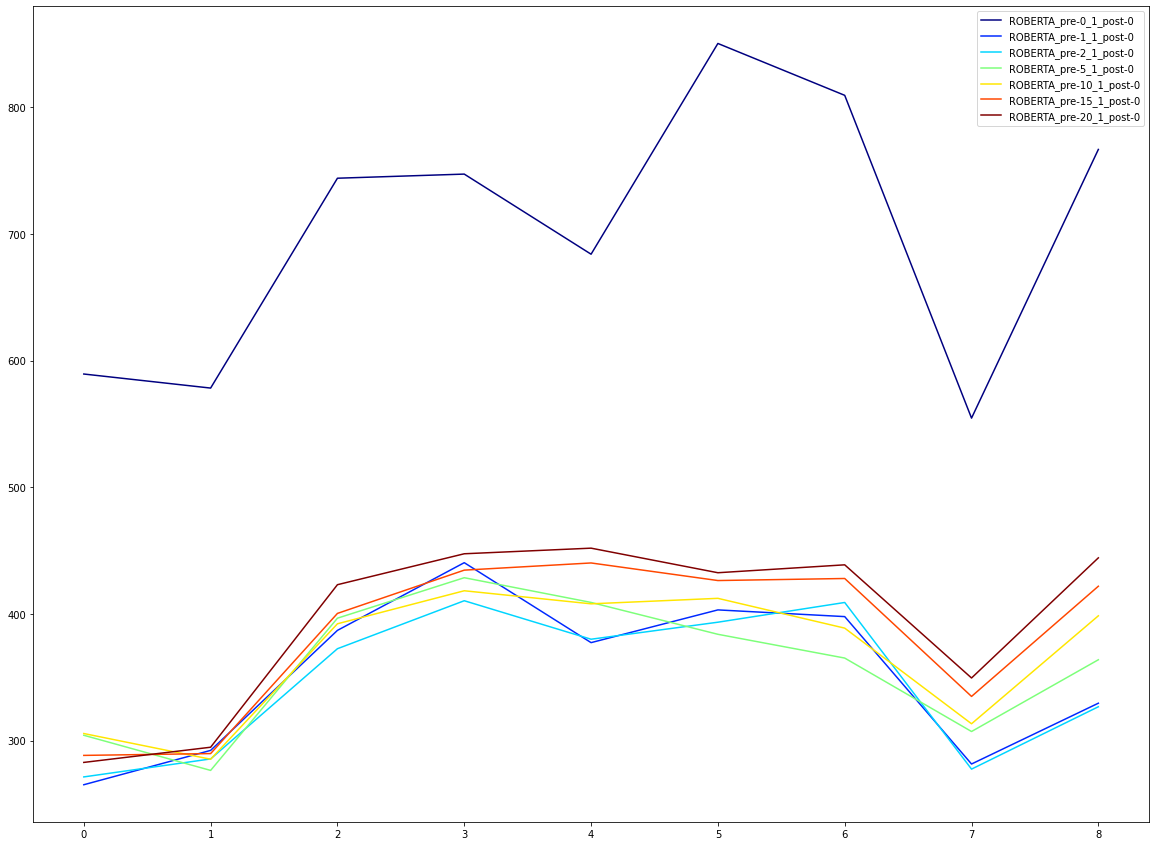

In [26]:
plt.figure()
results[['ROBERTA_pre-0_1_post-0', 
         'ROBERTA_pre-1_1_post-0', 
         'ROBERTA_pre-2_1_post-0', 
         'ROBERTA_pre-5_1_post-0', 
         'ROBERTA_pre-10_1_post-0', 
         'ROBERTA_pre-15_1_post-0',
         'ROBERTA_pre-20_1_post-0',
         #'ROBERTA_pre-10_1_post-1',
         #'ROBERTA_pre-10_1_post-2',
         #'ROBERTA_pre-10_1_post-5',
         #'ROBERTA_pre-10_1_post-7',
         #'ROBERTA_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

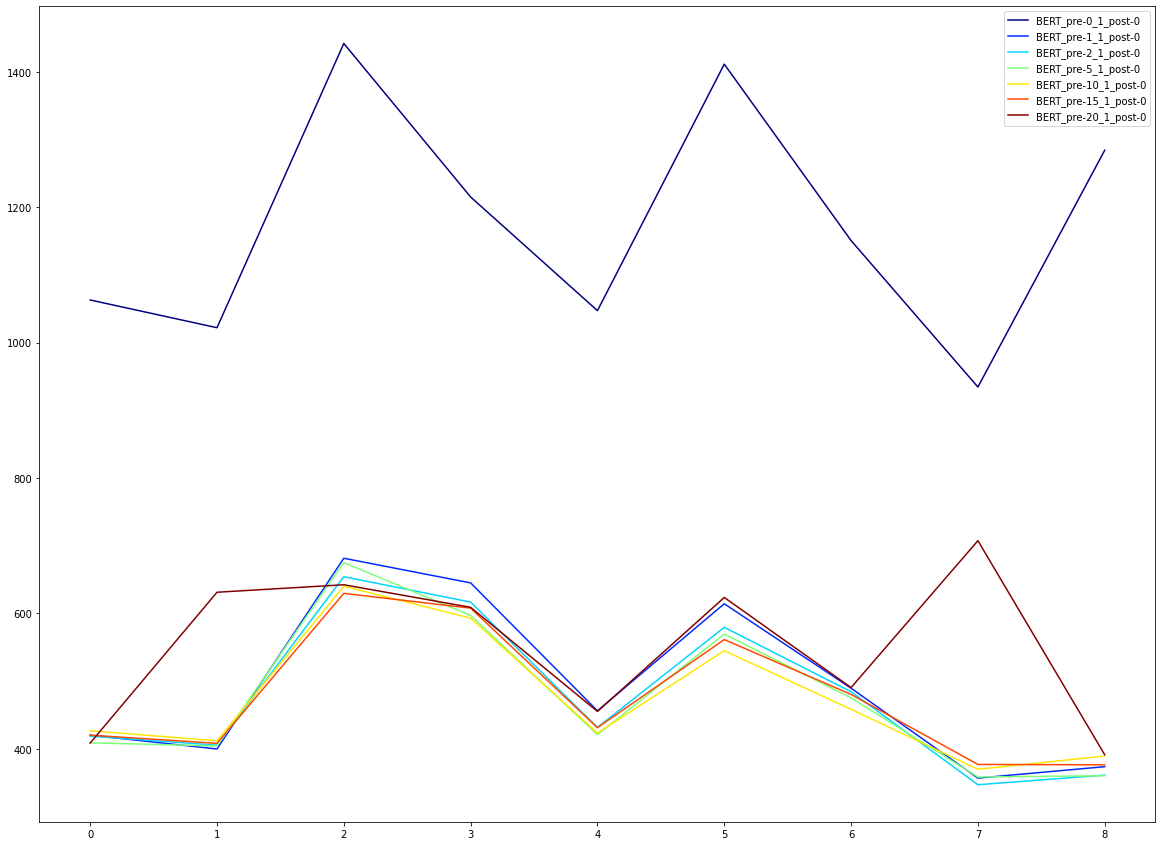

In [27]:
plt.figure()
results[['BERT_pre-0_1_post-0', 
         'BERT_pre-1_1_post-0', 
         'BERT_pre-2_1_post-0', 
         'BERT_pre-5_1_post-0', 
         'BERT_pre-10_1_post-0', 
         'BERT_pre-15_1_post-0',
         'BERT_pre-20_1_post-0',
         #'BERT_pre-10_1_post-1',
         #'BERT_pre-10_1_post-2',
         #'BERT_pre-10_1_post-5',
         #'BERT_pre-10_1_post-7',
         #'BERT_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

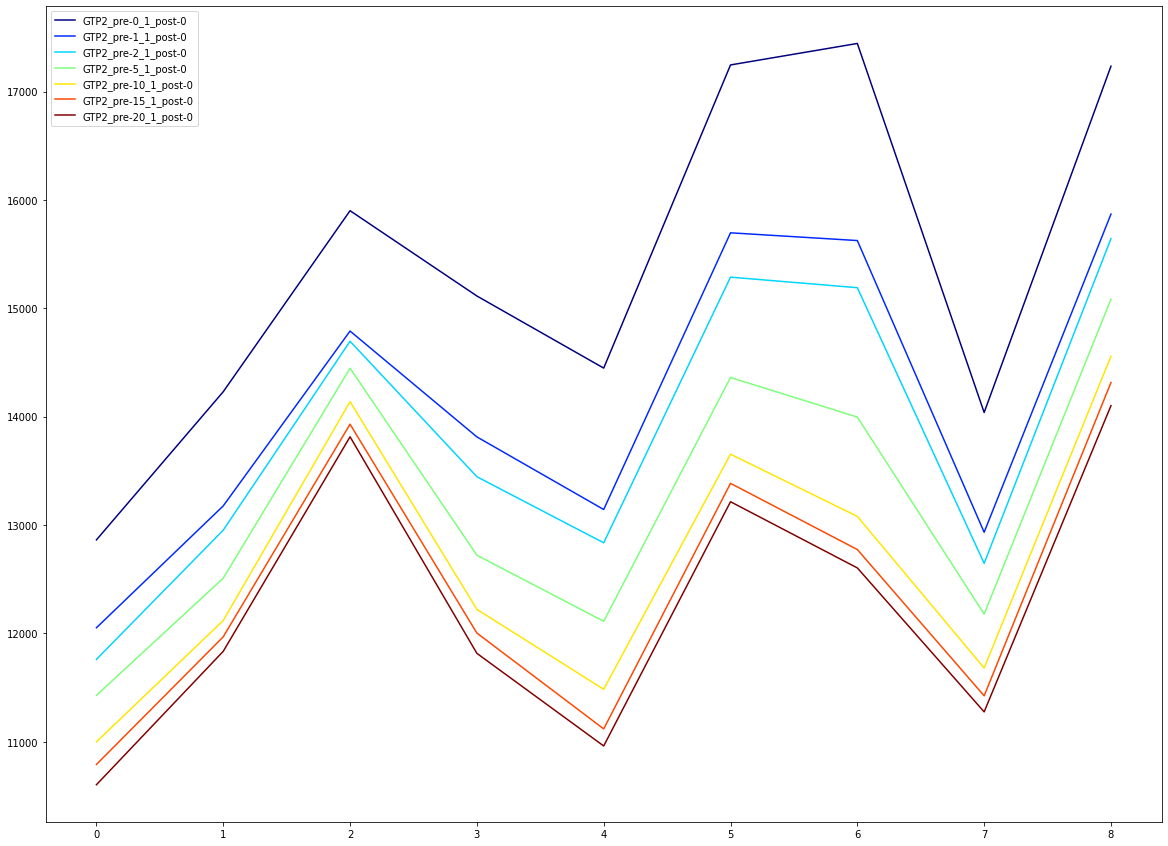

In [18]:
plt.figure()
results[['GTP2_pre-0_1_post-0', 
         'GTP2_pre-1_1_post-0', 
         'GTP2_pre-2_1_post-0', 
         'GTP2_pre-5_1_post-0', 
         'GTP2_pre-10_1_post-0', 
         'GTP2_pre-15_1_post-0',
         'GTP2_pre-20_1_post-0'
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

In [22]:
results.sum()

index                            0.000000
GTP2_pre-0_1_post-0         138519.186087
GTP2_pre-1_1_post-0         127098.680981
GTP2_pre-2_1_post-0         124456.608247
GTP2_pre-5_1_post-0         118836.206902
GTP2_pre-10_1_post-0        113931.617376
GTP2_pre-15_1_post-0        111706.216393
GTP2_pre-20_1_post-0        110223.152238
BERT_pre-0_1_post-0          10570.803308
BERT_pre-1_1_post-0           4437.864272
BERT_pre-2_1_post-0           4299.505485
BERT_pre-5_1_post-0           4270.480832
BERT_pre-10_1_post-0          4258.406681
BERT_pre-15_1_post-0          4292.954585
BERT_pre-20_1_post-0          4960.033549
BERT_pre-10_1_post-1          3980.690856
BERT_pre-10_1_post-2          3963.189298
BERT_pre-10_1_post-5          3983.377918
BERT_pre-10_1_post-7          4018.862359
BERT_pre-10_1_post-10         4053.650858
ROBERTA_pre-0_1_post-0        6323.606747
ROBERTA_pre-1_1_post-0        3173.781378
ROBERTA_pre-2_1_post-0        3125.986635
ROBERTA_pre-5_1_post-0        3234